In [65]:
from helper_funcs import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import io
dpi = 200


In [30]:
# daily highway incidents in california highway from start of 2017 to end of 2020
cal_data = pd.read_excel('../data/CalTransit_Dataset/pems_output.xlsx')
cal_data.head(10)
cal_data.rename({"Time": "x", "# Incidents": "y"}, axis=1, inplace=True)
print(len(cal_data))

1461


<Figure size 1000x600 with 0 Axes>

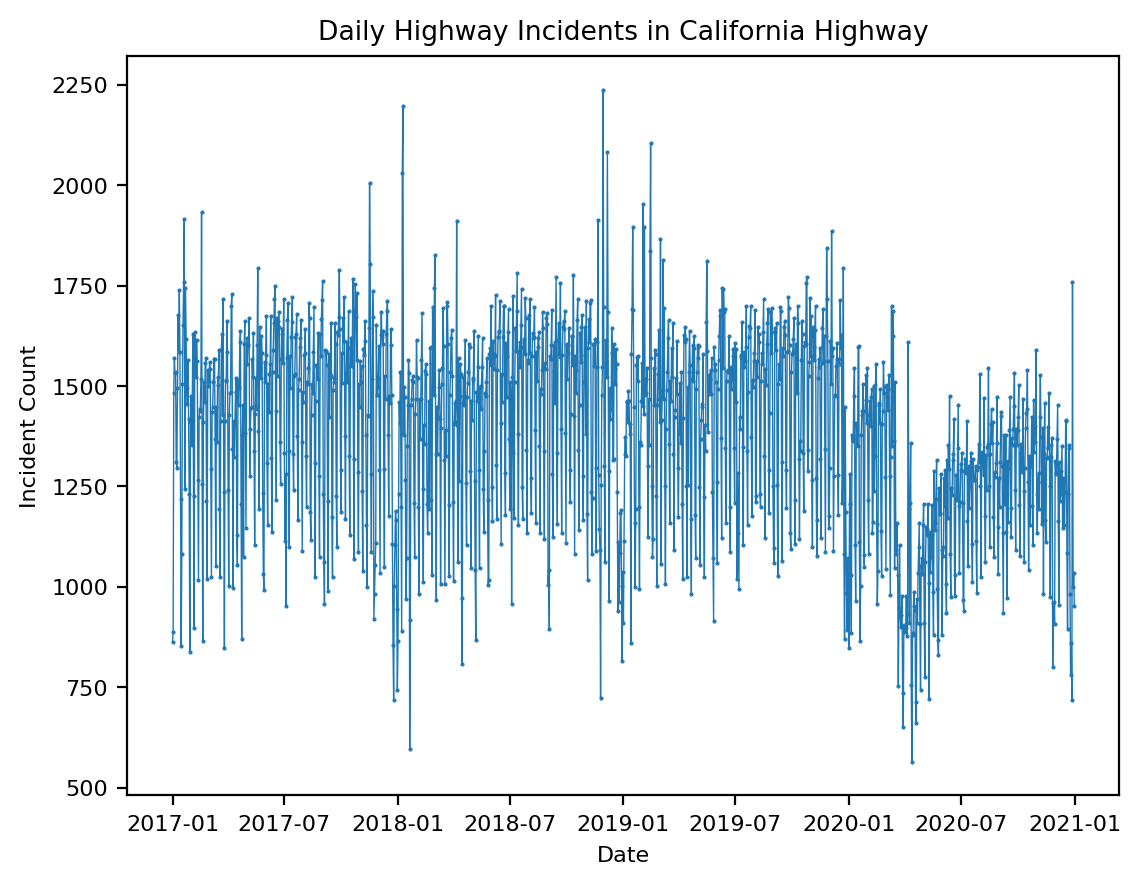

In [31]:
# plot the time series
# use thinner lines
plt.figure(figsize=(10, 6))
plt.figure(dpi=dpi)
plt.rcParams.update({'font.size': 8})
plt.plot(cal_data['x'], cal_data['y'], linewidth=0.5,marker='o',markersize=0.5)
plt.title('Daily Highway Incidents in California Highway')
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.show()


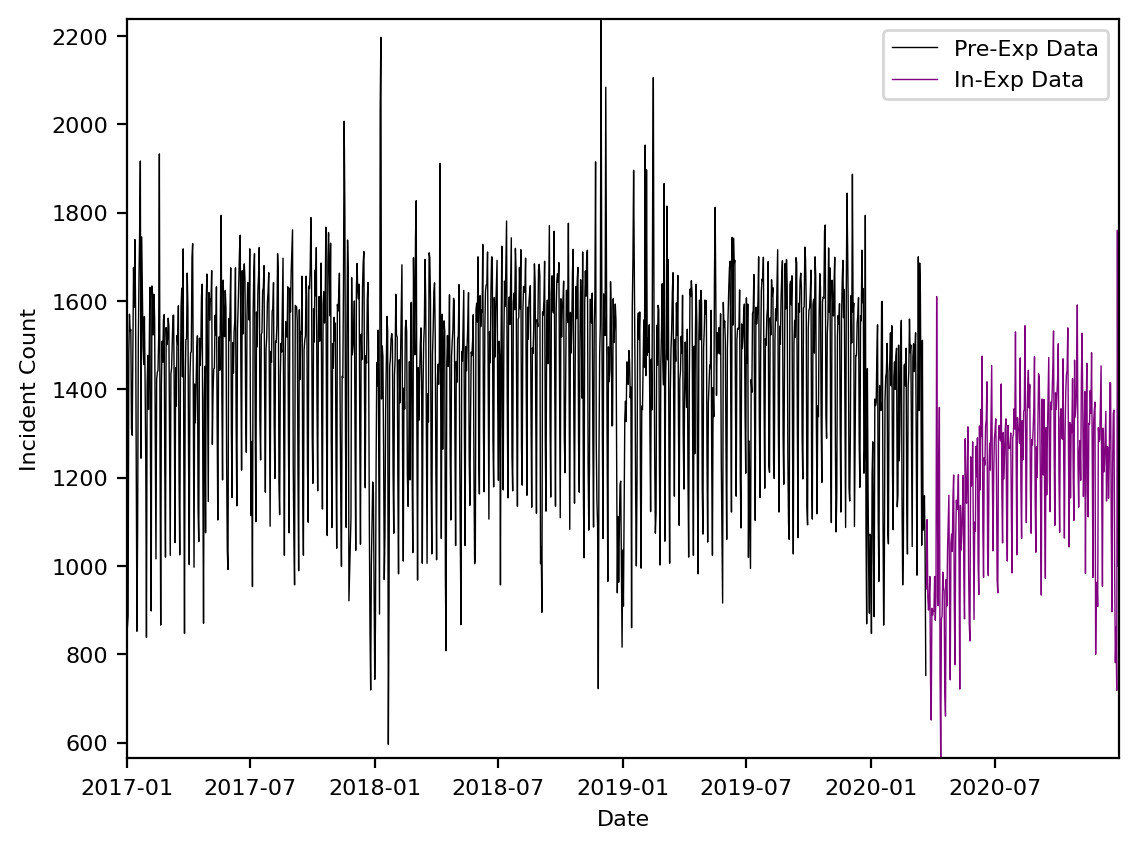

In [125]:
plt.figure(dpi=dpi)

# Separate train, validation, test data
n = cal_data.shape[0]
train_prop = 0.805
test_prop = 1 - train_prop
train_df = cal_data[:int(n*train_prop)].reset_index(drop=True)
test_df = cal_data[int(n*(1-test_prop)):].reset_index(drop=True)
# plot
x_range = [min(cal_data['x']), max(cal_data['x'])]
y_range = [min(cal_data['y']), max(cal_data['y'])]
plt.plot(train_df['x'], train_df['y'], color='black',linewidth=0.5,label='Pre-Exp Data')
plt.plot(test_df['x'], test_df['y'], color='purple',linewidth=0.5,label='In-Exp Data')
ax = plt.gca()
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_xlabel("Date")
ax.set_ylabel("Incident Count")
ax.legend()
plt.show()

<Figure size 1280x960 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

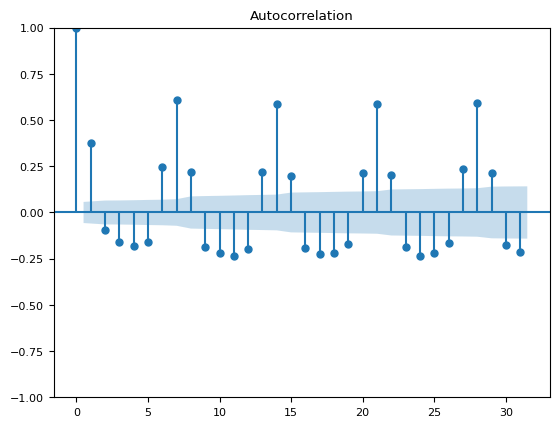

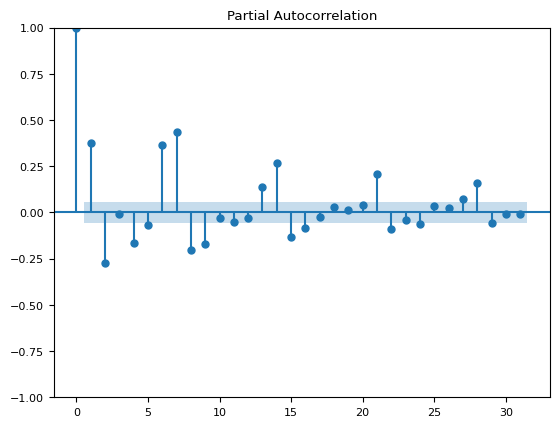

In [103]:
# plot autocorrelation and partial autocorrelation side by side
plt.figure(dpi=dpi)
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(train_df['y'])
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(train_df['y'])
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1280x960 with 0 Axes>

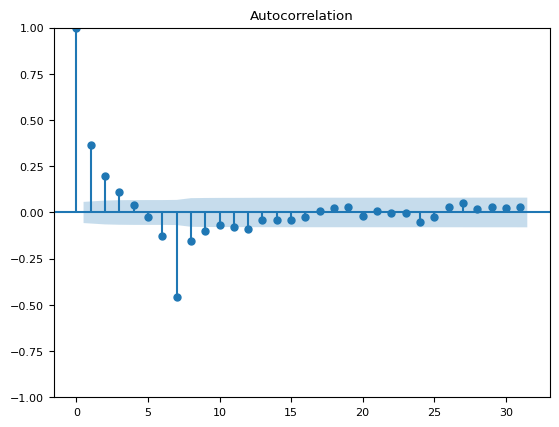

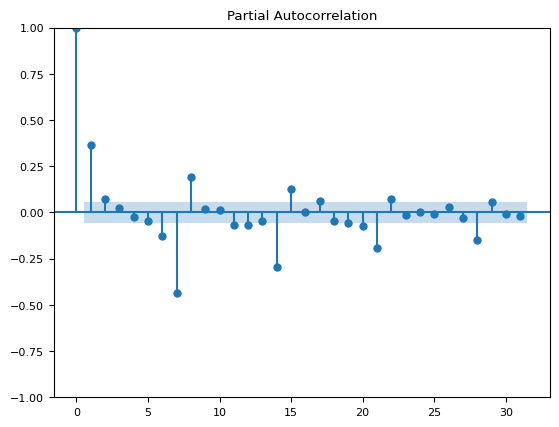

In [104]:
# seasonally differenced data, plot acf and pacf again
diff_y  = train_df['y'].diff(7).dropna()
plt.figure(dpi=dpi)
sm.graphics.tsa.plot_acf(diff_y)
plt.title('Autocorrelation')
sm.graphics.tsa.plot_pacf(diff_y)
plt.title('Partial Autocorrelation')
plt.show()

In [105]:
# Choose parameters to try fitting the model with
p = [0,1]
q = [0,1]
d = [0,1]
P = [0,1]
Q = [0,1]
D = [0,1] # dont need to test 0,1, just remove 1 if testing as run takes too long
S = [7]
#D = [0]
param1 = list(itertools.product(p,d,q))
param2 = list(itertools.product(P,D,Q,S))
best_param1 = param1[0]
best_param2 = param2[0]
for i in range(len(param1)):
    for j in range(len(param2)):
        #print(i,j)
        model = sm.tsa.statespace.SARIMAX(train_df['y'], order = param1[i], seasonal_order = param2[j])
        result = model.fit(disp=False)
        tb = result.summary().tables[0].as_html()
        readable_tb = pd.read_html(io.StringIO(tb),header=None,index_col=None)[0]
        cur_aic = readable_tb[3][2]
        if i == 0 and j == 0:
            best_aic = cur_aic
        elif cur_aic < best_aic:
            best_aic = cur_aic
            best_param1 = param1[i]
            best_param2 = param2[j]
best_aic, best_param1, best_param2


/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kmshim/Desktop/University of Waterloo/MastersWork/Two-Stage-Framework-for-Variance-Reduction/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(np.float64(14858.486), (1, 0, 1), (0, 1, 1, 7))

<Figure size 1000x600 with 0 Axes>

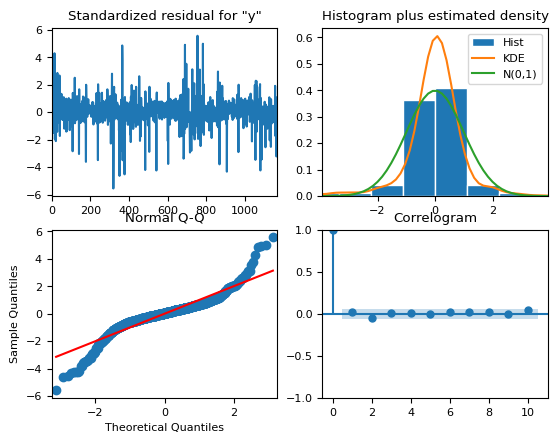

In [107]:
# fit the best model and check residuals
plt.figure(figsize=(10, 6))
opt_model = sm.tsa.statespace.SARIMAX(train_df['y'], order = best_param1, seasonal_order = best_param2)
opt_res = opt_model.fit(disp=False)
opt_res.plot_diagnostics()
plt.show()

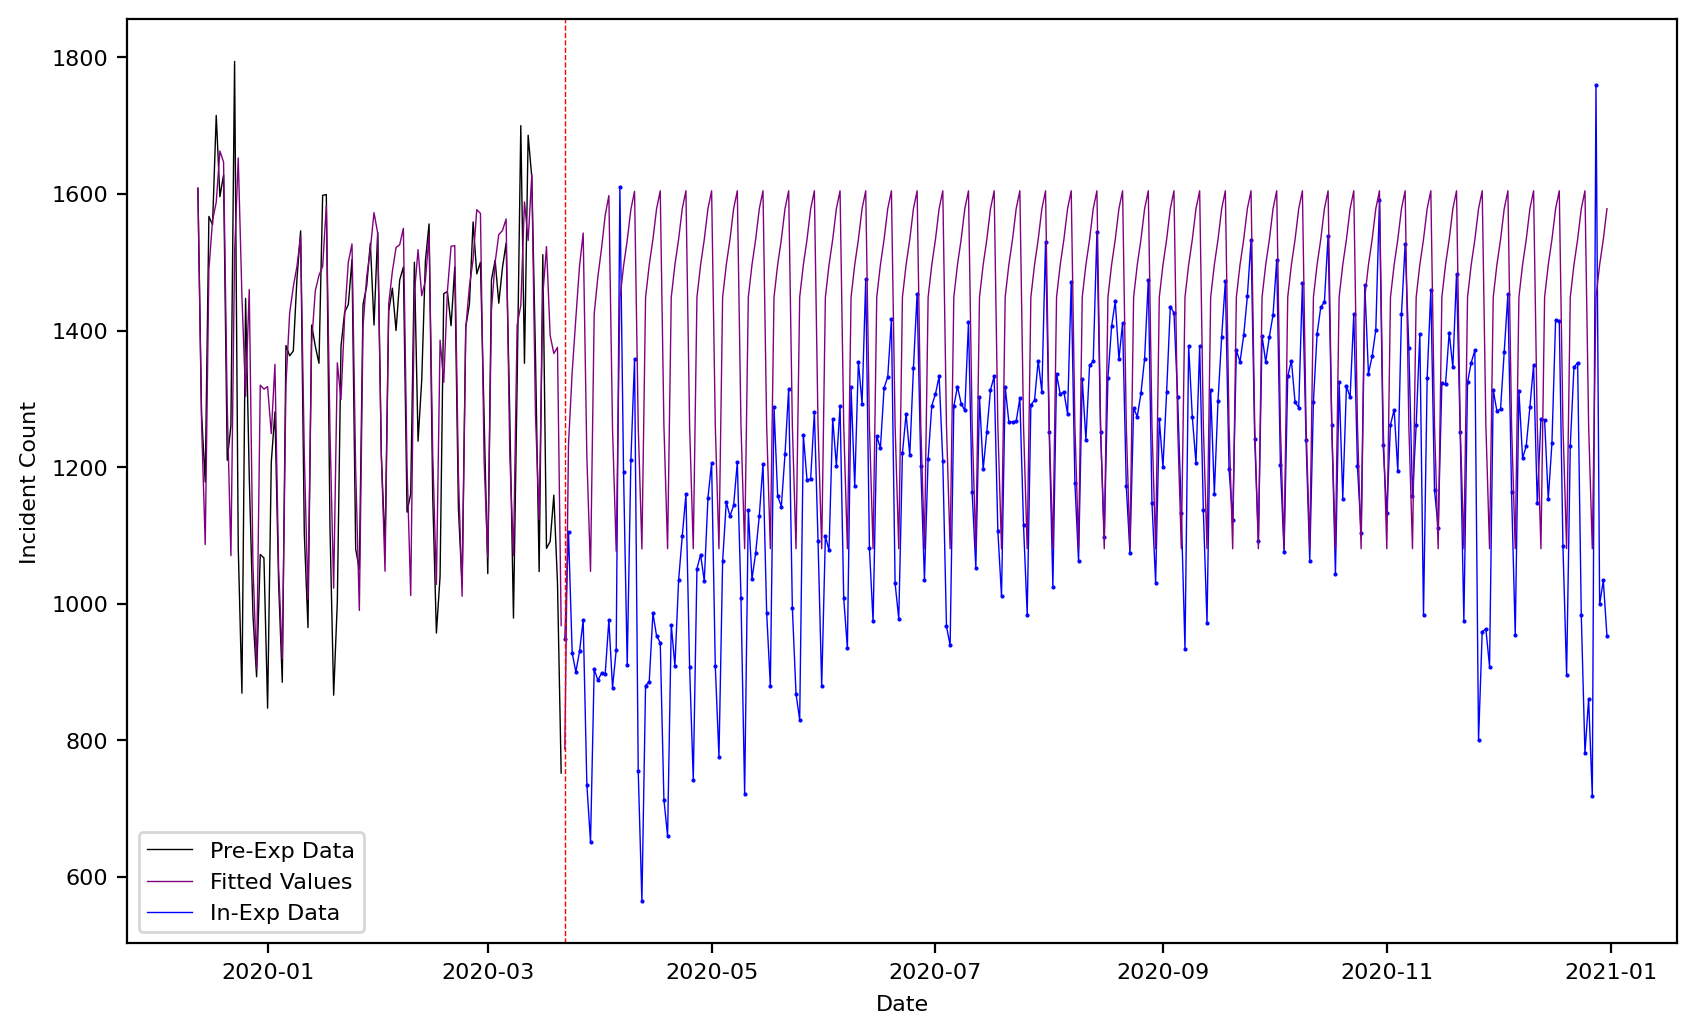

In [ ]:
# predict values for test data and plot against actual test data
plt.figure(figsize=(10,6), dpi = dpi)
pred = opt_res.get_prediction(start=train_df.index[-1]+1, end=train_df.index[-1]+len(test_df)) # watch index here as it is reset when train test split
pred_mean = pred.predicted_mean
train_bit = -200
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(test_df['x'], test_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(test_df['x'], test_df['y'], color='blue', linewidth = 0.5, label='In-Exp Data')
plt.plot(test_df['x'], pred_mean, color='purple', ls = '-', linewidth=0.5)
# plot a vertical line to show the start of the test data
plt.axvline(x=test_df['x'].iloc[0], color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend()
plt.show()



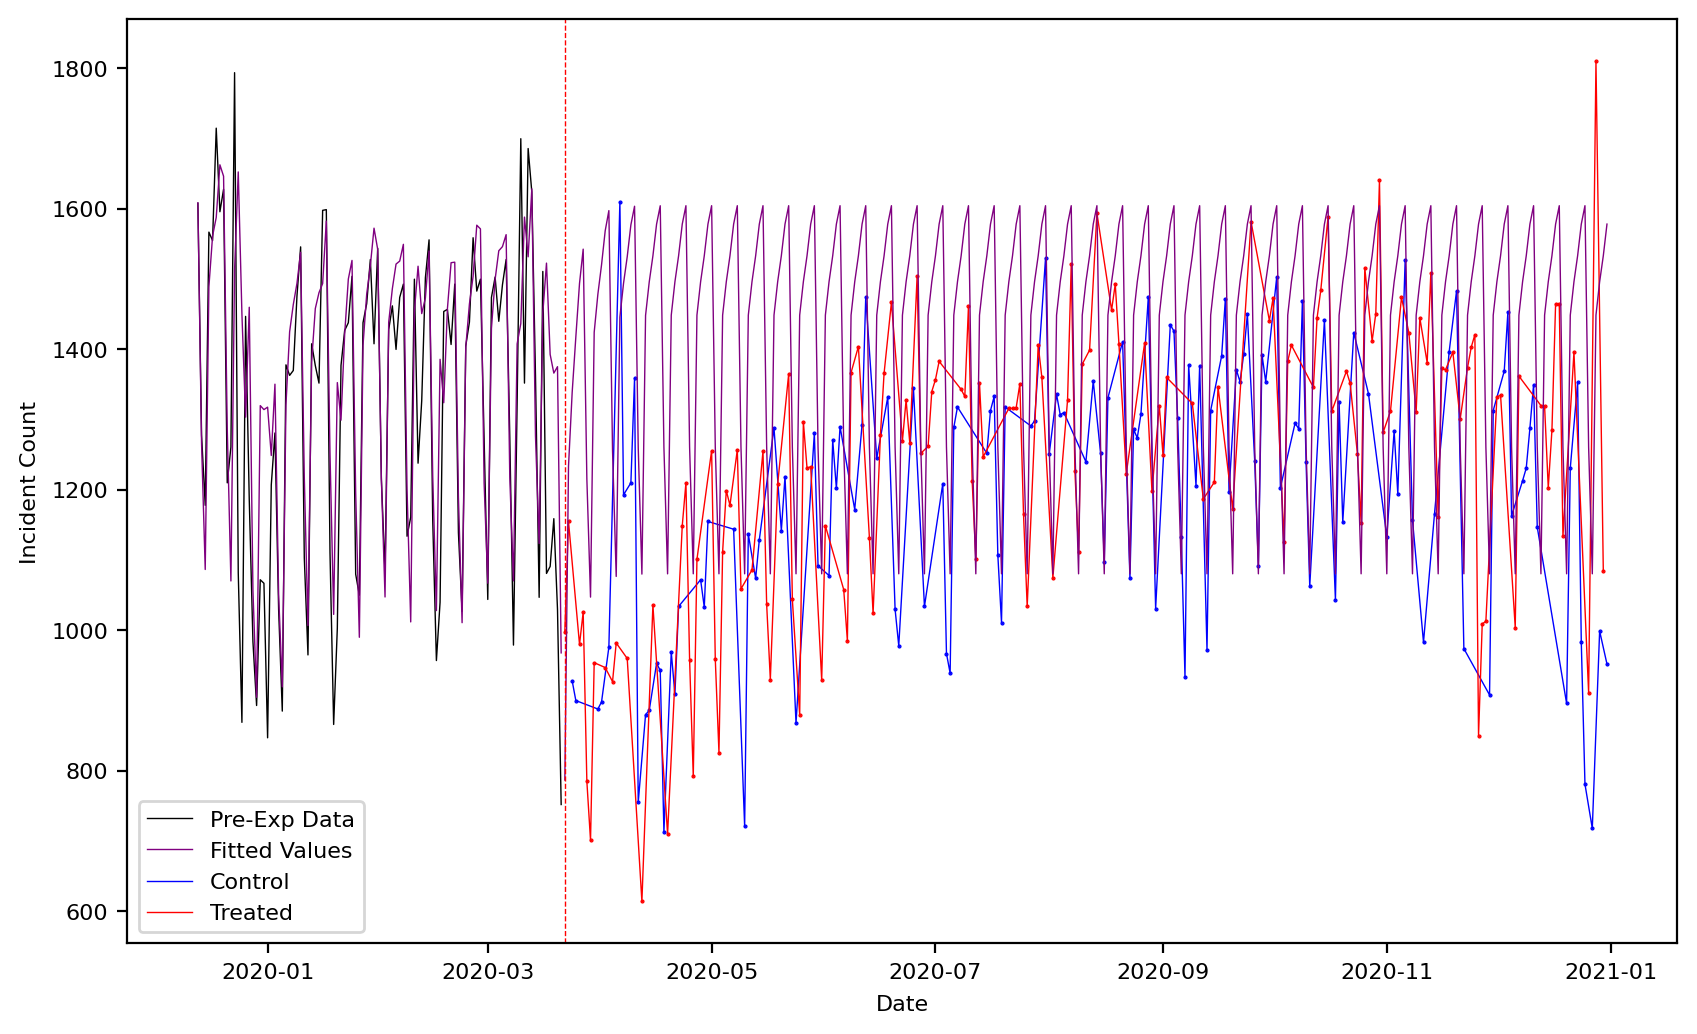

In [128]:
# simulate experiment by randomly assigning treatment to some data points
n = len(test_df)
np.random.seed(1)
# treatment effect - say increase of 20 incidents
te = 50
# randomly assign treatment
treatment = np.random.choice([0,1], n)
test_df['treatment'] = treatment
control_df = test_df[test_df['treatment'] == 0].reset_index(drop=True)
treated_df = test_df[test_df['treatment'] == 1].reset_index(drop=True)
treated_df['y'] = treated_df['y'] + te
# plot the above plot but with treated
plt.figure(figsize=(10,6), dpi = dpi)
plt.plot(train_df['x'][-100:], train_df['y'][-100:], color='black', linewidth=0.5, label='Pre-Exp Data')
plt.plot(train_df['x'][-100:], opt_res.fittedvalues[-100:], color='purple', linewidth=0.5, label='Fitted Values')
plt.plot(control_df['x'], control_df['y'], 'o', color='blue', markersize = 0.5)
plt.plot(control_df['x'], control_df['y'], color='blue', linewidth = 0.5, label='Control')
plt.plot(treated_df['x'], treated_df['y'], 'o', color='red', markersize = 0.5)
plt.plot(treated_df['x'], treated_df['y'], color='red', linewidth = 0.5, label='Treated')
plt.plot(test_df['x'], pred_mean, color='purple', ls = '-', linewidth=0.5)
plt.axvline(x=test_df['x'].iloc[0], color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Incident Count')
plt.legend()
plt.show()

In [129]:
# summarize data
print('Control Group')
print(control_df.describe())
print('Treated Group')
print(treated_df.describe())

Control Group
                                   x            y  treatment
count                            137   137.000000      137.0
mean   2020-08-12 17:31:05.693430784  1191.459854        0.0
min              2020-03-24 00:00:00   713.000000        0.0
25%              2020-06-04 00:00:00  1034.000000        0.0
50%              2020-08-21 00:00:00  1231.000000        0.0
75%              2020-10-11 00:00:00  1332.000000        0.0
max              2020-12-31 00:00:00  1610.000000        0.0
std                              NaN   194.330980        0.0
Treated Group
                                   x            y  treatment
count                            148   148.000000      148.0
mean   2020-08-09 09:34:03.243243264  1241.858108        1.0
min              2020-03-22 00:00:00   614.000000        1.0
25%              2020-05-27 18:00:00  1109.500000        1.0
50%              2020-08-04 00:00:00  1283.500000        1.0
75%              2020-10-26 12:00:00  1379.500000        